In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras.layers import Dense, InputLayer
from google.colab import files
from io import BytesIO
from PIL import Image

In [ ]:
upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
img_style = Image.open(BytesIO(upl['img_style.jpg']))

Saving img.jpg to img (5).jpg
Saving img_style.jpg to img_style (1).jpg


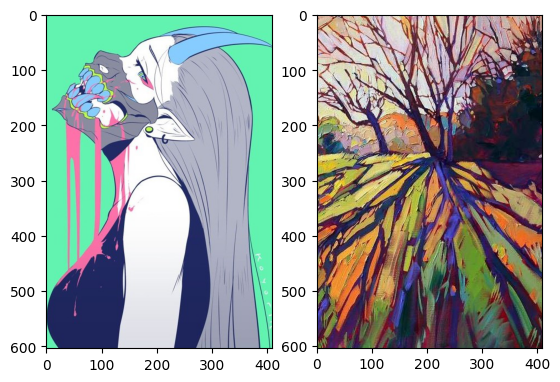

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow( img )
plt.subplot(1, 2, 2)
plt.imshow( img_style )
plt.show()

In [ ]:
x_img = keras.applications.vgg19.preprocess_input(np.expand_dims(img, axis=0))                #conversion to BGR format
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

def deprocess_img(processed_img):                     #to return the image to the original RGB format, we immediately define the following function
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of"
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
 
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')     #load the trained VGG19 network, but without a fully connected neural network at its end (we don’t need it)
vgg.trainable = False

In [ ]:
inputs = keras.Input(shape=(784,), name='img')                     #we will need to work with this network, feed images to its input and take computed feature maps at the outputs of certain layers
x = keras.layers.Dense(64, activation='relu')(inputs)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.models.Model(inputs, outputs)

content_layers=['block5_conv2']                                             #define auxiliary collections with layer names
style_layers=['block1_conv1',
             'block2_conv1',
             'block3_conv1',
             'block4_conv1',
             'block5_conv1']

print(vgg.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
num_content_layers=len(content_layers)
num_style_layers=len(style_layers)

style_outputs = [vgg.get_layer(name).output for name in style_layers]       #get layers for our model
content_outputs = [vgg.get_layer(name).output for name in content_layers]

model_outputs = style_outputs + content_outputs
 
print(vgg.input)
for m in model_outputs:
  print(m)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

In [ ]:
model = keras.models.Model(vgg.input, model_outputs)                        #model
for layer in model.layers:
    layer.trainable = False 
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
outs = model(x_img)

In [ ]:
def get_feature_representations(model):
  # batch compute content and style features
  style_outputs = model(x_style)
  content_outputs = model(x_img)
 
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

def get_content_loss(base_content, target):                     #Mean square difference across content can be calculated using the built-in methods of the Tensorflow package
  return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):                  #implementation of a function that will calculate the size of the squares of the mismatch between the style maps of the generated image and the style image
  gram_style = gram_matrix(base_style)
 
  return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):  #general function to calculate all losses
  style_weight, content_weight = loss_weights
 
  model_outputs = model(init_image)
 
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
 
  style_score = 0
  content_score = 0
 
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
 
  style_score *= style_weight
  content_score *= content_weight
 
  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

num_iterations=100         #determine the number of iterations of the algorithm and parameters to take into account the weight of the content in the generated image and styles
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)                   #compute style and content maps for initial images
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)                                  #compute style and content maps for initial images
init_image = tf.Variable(init_image, dtype=tf.float32)

#optimizer, current iteration number, variables to store the image with the least loss and best styling, and a tuple of alpha and beta parameters.
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)  
iter_count = 1
 
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {                                                     #Let's create a configuration dictionary
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])             #Auxiliary variables for converting generated images to RGB format
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

In [ ]:
for i in range(num_iterations):                               #running the gradient descent algorithm itself
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
 
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)
 
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
 
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())
 
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      print('Iteration: {}'.format(i))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

tf.Tensor(13000847.0, shape=(), dtype=float32)


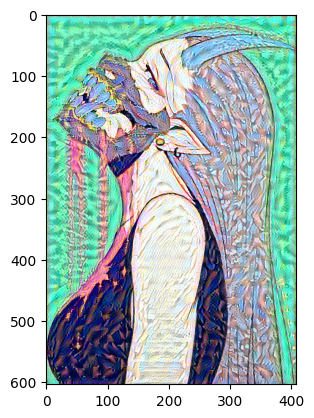

In [ ]:
plt.imshow(best_img)
print(best_loss)

In [ ]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save('out.jpg')
files.download('out.jpg')